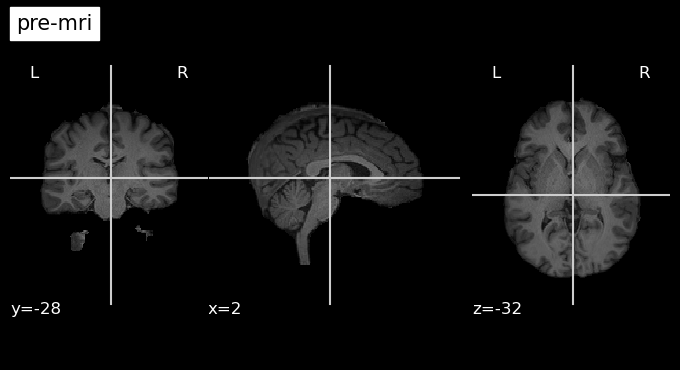

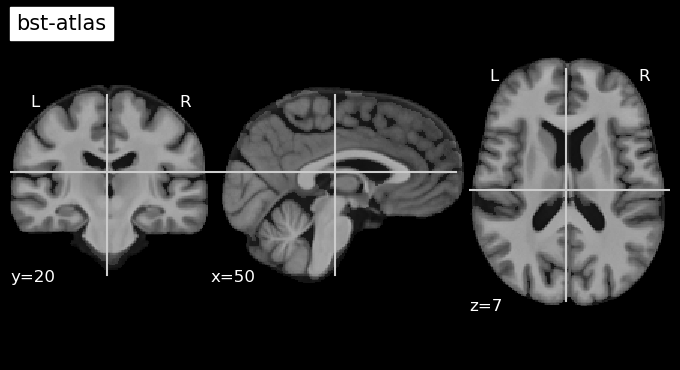

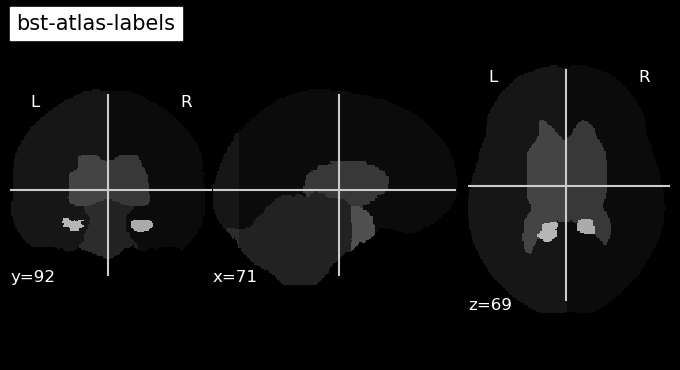

In [4]:
from aligner import Aligner
from monai.transforms import (
    LoadImage,
    Resize,
    EnsureChannelFirst,
    ScaleIntensityRangePercentiles,
)
import nibabel as nib
from nilearn.plotting import plot_anat
import matplotlib.pyplot as plt
import matplotlib
from warp_utils import apply_warp



pre_mri = '/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/sub-M1998N33-M1998N33_MRI.bse.nii.gz' 

bst_atlas = '/deneb_disk/auto_resection/bst_atlases/T1_brain_t1.nii.gz'
bst_atlas_labels = '/deneb_disk/auto_resection/bst_atlases/T1_brain_t1.label.nii.gz'

plot_anat(pre_mri,title='pre-mri')
plot_anat(bst_atlas,title='bst-atlas')
plot_anat(bst_atlas_labels,title='bst-atlas-labels')


In [5]:
affine_reg = Aligner()

ddf = "ddf_temp.nii.gz"
out_img = "out_img.nii.gz"
out_labels = "out_labels.nii.gz"

affine_reg.affine_reg(
    fixed_file=pre_mri,
    moving_file=bst_atlas,
    output_file=out_img,
    ddf_file=ddf,
    loss="mi",
    nn_input_size=64,
    lr=1e-6,
    max_epochs=3000,
    device="cuda",
)


moving = LoadImage(image_only=True)(bst_atlas_labels)
moving = EnsureChannelFirst()(moving)

target = LoadImage(image_only=True)(pre_mri)
target = EnsureChannelFirst()(target)


image_movedo = apply_warp(affine_reg.ddf[None,], moving[None,], target[None,])

nib.save(
    nib.Nifti1Image(image_movedo[0, 0].detach(
    ).cpu().numpy(), affine_reg.target.affine),
    out_labels,
)

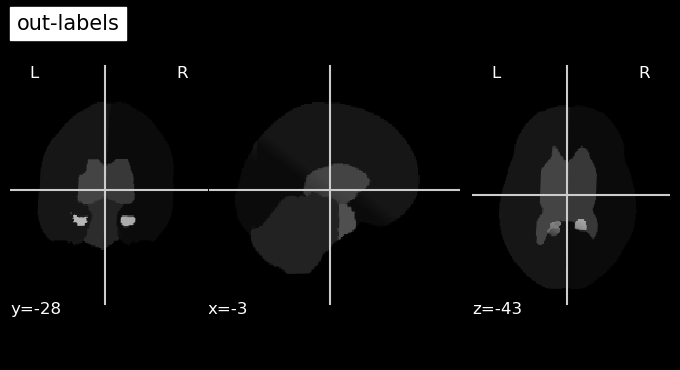

In [6]:
plot_anat(out_labels,title='out-labels')